#### [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 


---
## (４章　続き)

### 実装の設計
活性化関数などの変更を容易にする、効率の良いモデル実装について考える。

TensorFlow公式サイトのGet Started - [TensorFlow Mechanics 101](https://www.tensorflow.org/get_started/mnist/mechanics)では、  
グラフを３つの段階に分けて作成する手法を紹介している。

>After creating placeholders for the data, the graph is built from the [mnist.py](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist.py) file according to a 3-stage pattern: inference(), loss(), and training().
- inference() - Builds the graph as far as required for running the network forward to make predictions.
- loss() - Adds to the inference graph the ops required to generate loss.
- training() - Adds to the loss graph the ops required to compute and apply gradients.

また、これに学習部分を加えることでモデルを更に扱いやすくすることができる。  
実装の一例は次の通り。  

In [32]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

# n_hiddens= [n_hidden_1, ..., n_hidden_last]

class DNN(object):
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_hiddens = n_hiddens
        self.n_in = n_in
        self.n_out = n_out
        self.weights = []
        self.biases = []
        
        self._x = None
        self._t = None
        self._keep_prob = None
        self._sess = None
        self._history = {
            'accuracy': [],
            'loss': [],
            'val_loss': [],
            'val_acc': []
        }
    
    def weight_variable(self, shape):
        initial = np.sqrt(2.0 / shape[0]) * tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)
    
    def inference(self, x, keep_prob):
        
        for i, n_hidden in enumerate(self.n_hiddens[:-1]):
            if i==0:
                input_data = x
                input_dim = self.n_in
            else:
                input_data = output
                input_dim = self.n_hiddens[i-1]
            
            self.weights.append(self.weight_variable([input_dim, n_hidden]))
            self.biases.append(self.bias_variable([n_hidden]))
            
            h = tf.nn.relu(tf.matmul(input_data, self.weights[-1]) + self.biases[-1])
            output = tf.nn.dropout(h, keep_prob)
            
        self.weights.append(self.weight_variable([self.n_hiddens[-1], self.n_out]))
        self.biases.append(self.bias_variable([self.n_out]))
        y = tf.nn.softmax(tf.matmul(output, self.weights[-1]) + self.biases[-1])
        return y
                
    def loss(self, y, t, delta=1e-10):
        # model can fit with either definition
        
        #cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y + delta), reduction_indices=[1]))
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(tf.clip_by_value(y, delta, 1.0)), reduction_indices=[1]))
        return cross_entropy
    
    def training(self, loss, optimizer_name='SGD', parameter=[0.01]):
        if optimizer_name == 'Momentum':
            optimizer = tf.train.MomentumOptimizer(parameter[0], parameter[1])
        else:
            optimizer = tf.train.GradientDescentOptimizer(parameter[0])
        train_step = optimizer.minimize(loss)
        return train_step
    
    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
        accuracy_value = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy_value
    
    def fit(self, X_train, Y_train, epochs=1, batch_size=1, p_keep=0.5, verbose=1, optimizer_name='SGD', parameter=[0.01]):
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        keep_prob = tf.placeholder(tf.float32)
        self._x = x
        self._t = t
        self._keep_prob = keep_prob
        
        y = self.inference(x, keep_prob)
        loss = self.loss(y, t)
        train_step = self.training(loss, optimizer_name, parameter)
        self.accuracy_value = self.accuracy(y,t)
        
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)
        self._sess = sess
        
        N_train = len(X_train)
        n_batches = N_train // batch_size
        
        for epoch in range(epochs):
            X_, Y_ = shuffle(X_train, Y_train)
            
            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size
                
                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
                
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                keep_prob: 1.0
            })
            val_acc = self.accuracy_value.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                keep_prob: 1.0
            })
            self._history['val_loss'].append(val_loss)
            self._history['val_acc'].append(val_acc)
        
            
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            accuracy_ = self.accuracy_value.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)

            if verbose:
                print('epoch:{}'.format(epoch), '\nloss:{}'.format(loss_), '\naccuracy:{}'.format(accuracy_))
            
        return self._history
            
    def evaluate(self, X_test, Y_test):
        return self.accuracy_value.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })
            
        
        
        

In [34]:
# MNIST dataset
#  for hold-out validation

import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def set_mnist_dataset(data_size=10000, train_size=0.6, validation_size=0.2, test_size=0.2, onehot=True):
        mnist = fetch_mldata('MNIST original', data_home="./dataset")
        indices = np.random.permutation(len(mnist.data))[:data_size]
        X = mnist.data[indices]
        Y = mnist.target[indices]
        
        if onehot:
            Y = np.eye(10)[Y.astype(int)]
        X_train, X_test, Y_train, Y_test = \
            train_test_split(X, Y, train_size=train_size, test_size=test_size)
            
        if validation_size != 0:
            X_train, X_validation, Y_train, Y_validation = \
                train_test_split(X_train, Y_train, 
                                 train_size=round(train_size/(train_size+validation_size), 2), 
                                 test_size=1.-round(train_size/(train_size+validation_size), 2))
            return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
        else:
            return X_train, X_test, Y_train, Y_test

accuracy : 0.9455000162124634


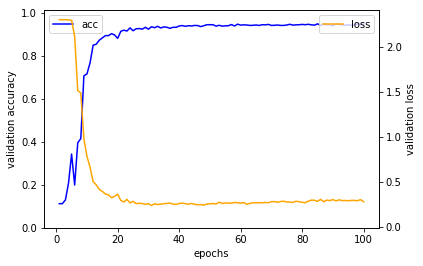

In [35]:
# usage example

import matplotlib.pyplot as plt

# for examination with same seed as in the book
#np.random.seed(0)
#tf.set_random_seed(1234)


# model definition
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = \
    set_mnist_dataset(data_size=10000,  train_size=0.6, validation_size=0.2, test_size=0.2)
n_in, n_out = X_train[0].shape[0], Y_train[0].shape[0]

n_hidden = [200, 200, 200]
model = DNN(n_in, n_hidden, n_out)


# fit
history = model.fit(X_train, Y_train, epochs=100, batch_size=200, p_keep=0.5, 
          verbose=0, optimizer_name='SGD', parameter=[0.01])

accuracy = model.evaluate(X_test, Y_test)
print('accuracy : {}'.format(accuracy))


# plots
def plots(history, epochs):
    fig, ax1 = plt.subplots()
    ax1.plot(np.array(range(epochs))+1, history['val_acc'], label='acc', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(np.array(range(epochs))+1, history['val_loss'], label='loss', color='orange')
    ax1.set_ylim(0,1.01)
    ax2.set_ylim(-0.01,None)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('validation accuracy')
    ax2.set_ylabel('validation loss')
    ax1.legend()
    ax2.legend()
    plt.show()
    
plots(history, epochs=100)

---
### Normalizing Dataset
入力する元データの正規化によって予測性能が向上することが知られている。  
  
単純な正規化手法の１つは、対象とするデータセット $X = \{X_{i}\} \, (i=1,\dots,N)$ 中の  
任意のデータ $X_{i}$ がひとつの実数値である場合に、  
各データから全体の平均を引いてデータセット中の最大値で割ること、すなわち  

\begin{align*}
X_{\text{normalized}, \, i} = \frac{X_{i} - \overline{X}}{\max(X)}
\end{align*}

~~~python
import numpy as np

X = (X - np.mean(X))/np.max(X)
~~~

とすることである。  
$X_{i}$ が複数の実数値の配列であり、それぞれの値を例えば身長と体重のように別個に扱って良い場合には、  
同じ位置の各数値について同様に正規化すればよい。  
    
また、$X_{i}$ が正規分布 $ \mathrm{N}(\mu, \sigma^{2}) $ に従う確率変数であると分かっている場合には、
標準化変数 $Z$ を用いて  
  
\begin{align*}
Z = \frac{X - \mu}{\sigma}
\end{align*}

~~~python
import numpy as np

Z = (X - np.mean(X,axis=0))/np.std(X, axis=0)
~~~

と変形して、必要なら上のようにscalingすればよい。 
  
ニューラルネットワークの学習は各素性のscaleに影響されるため、  
これを [0,1] ないし [-1,1] の範囲に収めることは重要である。  
  
各訓練データが実数の配列として表現され、訓練データと評価データが同じ分布に従う（or 近似できる）場合には  
訓練データセットについて求めた平均値と最大値を使って上のように正規化しすればよい。  
この場合、評価データまたは運用時データについても訓練時と同じ平均値と最大値を使ってscalingする必要がある。  

実際の正規化については対象領域のドメイン知識を要するが、  
例えば対象の画像データがRGB形式で表現されているならば  
 - 各画像データは (Width, Height) という並びのピクセルデータの配列で  
 - 各ピクセルデータは (R, G, B) という形状で  
 - その要素は$ (0 \leq R,G,B \leq 255) $ の範囲にある整数であり
 - ピクセル間の大小や相対位置が重要　＝　各ピクセルを個別に正規化できない

ので、全てのピクセルデータについて一律に

\begin{align*}
(R, G, B)_{normalized} = (R/255, G/255, B/255)
\end{align*}
　
と scaling するだけでも十分な効果がある。 

---
### PCA and Whitening
　参考：  
　・[CS231n | Setting up the data and the model](http://cs231n.github.io/neural-networks-2/)  
　・[Cousera, Machine Learning : Lecture 85 - Principal Component Analysis Algorithm](https://www.coursera.org/learn/machine-learning/lecture/ZYIPa/principal-component-analysis-algorithm)  
　・[主成分分析(PCA)がなぜ分散共分散行列を対角化する固有値問題となるか](http://yusuke-ujitoko.hatenablog.com/entry/2017/03/04/193628)  
　・[特異値分解の定義，性質，具体例](https://mathtrain.jp/svd)  
　・[Pythonで特異値分解してみる](https://qiita.com/kyoro1/items/4df11e933e737703d549)  
　・[PCAとSVDの関連について](https://qiita.com/horiem/items/71380db4b659fb9307b4)  
  
$\,$  
***主成分分析*** （PCA, Principal component analysis）は次元の縮小に関する手法で、  
射影したデータの分散が最大となるような軸を探すことで「主成分」を順に求める手法である。  
これは教師なし学習の一手法とみなすこともできる。  
  
アルゴリズムの概略は次の通り。  
　１　全データの重心を求める  
　２　重心からデータの分散が最大となるような新しい座標軸を見つける  
　３　２で求めた方向を基底とする  
　４　この新たな座標軸と直行する方向に対して、分散が最大となるような次の座標軸を探す  
　５　２〜３を繰り返す  
  
実装例は次の通り。

In [ ]:
# Assume input data matrix X of size = (N, D) | N:number of data, D:their dimensionality

# mean subtruction to zero-centering
X -= np.mean(X, axis=0)

# get covariance matrix
cov = np.dot(X.T, X) / X.shape[0]

# singular value decomposition. | U: [D*D] eigenvectors, S:1-D array of the singular values
U,S,V = np.linalg.svd(cov)

# decorrelate the data
Xrot = np.dot(X, U)

# PCA dimensionality reduction, becomes[N * K]
Xrot_reduced = np.dot(X, U[:,:K])

# whitening
Xwhite = Xrot / np.sqrt(S + 1e-8)

In [11]:
# example to run PCA
import numpy as np
A = np.array([[1,2,3],[4,8,12],[7,9,8],[-3,11,3]])
Azc = A - np.mean(A, axis=0)
cov = np.dot(Azc.T, Azc) / Azc.shape[0]
U,S,V = np.linalg.svd(cov)
Arot = np.dot(Azc, U)
Arot_reduced = np.dot(Azc, U[:,:2])

print("input data matrix A \n{}\n".format(A))
print("(N, D) = {}\n".format(A.shape))
print("covariance matrix  \n{}\n".format(cov))
print("eigenvectors U \n{}\n".format(U))
print("decorrelated A  \n{}\n".format(Arot))
print("PCA-reduced A example (becomes [N,2] shape) \n{}".format(Arot_reduced))

input data matrix A 
[[ 1  2  3]
 [ 4  8 12]
 [ 7  9  8]
 [-3 11  3]]

(N, D) = (4, 3)

covariance matrix  
[[ 13.6875  -0.875    9.875 ]
 [ -0.875   11.25     3.    ]
 [  9.875    3.      14.25  ]]

eigenvectors U 
[[-0.67952872  0.3166907  -0.66177618]
 [-0.12316155 -0.93847513 -0.32263859]
 [-0.72323713 -0.1377368   0.67672493]]

decorrelated A  
[[ 4.05812941  5.24782867  0.23319522]
 [-5.22856026 -0.67258126  2.40255948]
 [-4.49735946 -0.11003708 -2.61230736]
 [ 5.66779031 -4.46521032 -0.02344733]]

PCA-reduced A example (becomes [N,2] shape) 
[[ 4.05812941  5.24782867]
 [-5.22856026 -0.67258126]
 [-4.49735946 -0.11003708]
 [ 5.66779031 -4.46521032]]


---
ここで使用した SVD（特異値分解）とは行列分解の一手法である。  
  
$m$ 行 $n$ 列の行列 $A$ に対して  

 - $ U : m \times m $ のユニタリ行列
 - $ \Sigma : $ 行、列が $ min(m,n) $ の実対角行列（成分は非負）と零行列からなる $ m \times n $ 行列
 - $ V : n \times n $ のユニタリ行列

が存在して    

\begin{equation*}
A = U \Sigma \overline{V^{\mathrm{T}}}
\end{equation*}

が成立し、このような $U, \Sigma, V$ を求めることをいう。    
  
固有値分解はSVDの特殊なケースにあたる。  
$n$ 次正方行列 B に対して $B\mathbf{x} = \lambda \mathbf{x}$ を満たす $\mathbf{x} \neq 0$ を B の固有ベクトル、$\lambda$ をBの固有値といい、  
固有値 $\lambda_{1}, \dots, \lambda_{n}$ に対応する固有ベクトルを $\mathbf{x}_{1}, \dots, \mathbf{x}_{n}$ とするとき

\begin{align*}
P :=& \, \left[ \mathbf{x}_{1} \dots \mathbf{x}_{n} \right] \\
\Lambda :=& \, \left[ \begin{array}{ccc} \lambda_{1} & & 0\\ & \ddots & \\ 0 & & \lambda_{n} \end{array} \right] 
\end{align*}
 
である行列 $P, \Lambda$ によって $B$ を
  
\begin{align*}
B = P \Lambda P^{\mathrm{T}}
\end{align*}

と分解することができる。  

PCAの上記実装例では対象とする行列Aから平均を引いた後に
共分散行列 $cov = AA^{\mathrm{T}} / N$ の特異値分解を行うが、  
covは対称行列であり、得られる $U, S, V$ はそれぞれ $P, \Lambda$の対角成分$, P^{\mathrm{T}}$ に対応するので  

~~~python
np.dot(np.dot(U, np.diag(S)), V)
~~~

は共分散行列covに浮動小数点演算による誤差の範囲内で一致する。

---
Whitening (白色化) はデータの共分散行列が単位行列となるような変換をすることで、  
共分散行列 $S$ が  

\begin{align*}
S = P \Lambda P^{\mathrm{T}}
\end{align*}

と固有値分解されるとき、白色化変換は

\begin{align*}
\tilde{\mathbf{x}} = \Lambda^{-\frac{1}{2}} P^{\mathrm{T}} (\mathbf{x} - E(\mathbf{x}))
\end{align*}

と表される。

以下は各データが２次元実数ベクトルで表されるデータセットXに対して  
正規化、主成分分析、白色化を施した結果を図示したもの。  

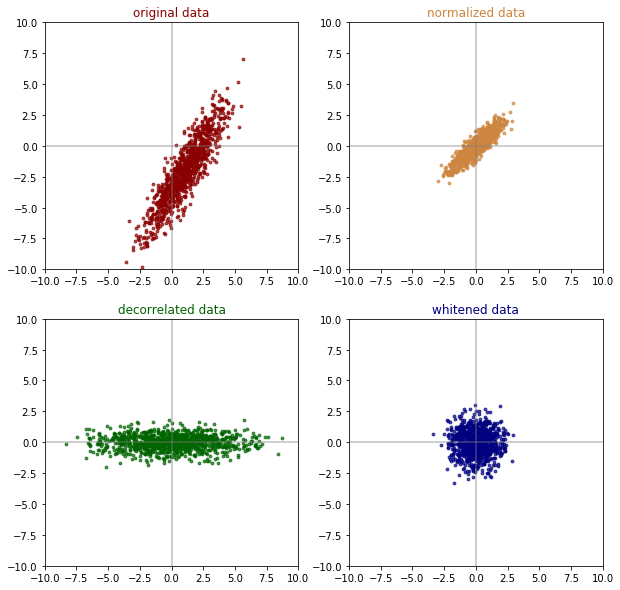

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def stretch_rotate_move(x, sw, sh, rad, mw, mh):
    stretched = x * (sw, sh)
    rotated = np.dot(np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]]), stretched)
    moved = rotated + (mw, mh)
    return moved

def normalize(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

def pca_and_whitening(X):
    Xc = X - np.mean(X, axis=0)
    cov = np.dot(Xc.T, Xc) / Xc.shape[0]
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(Xc, U)
    Xwhite = Xrot / np.sqrt(S + 1e-8)
    return Xrot, Xwhite

# dataset
X = np.random.randn(1000,2)
Xr = np.array([stretch_rotate_move(x, 3, 0.6, np.pi*(1/3), 1, -2) for x in X])

# pca and whitening
Xn = normalize(Xr)
Xrot, Xwhite = pca_and_whitening(Xr)

Xlines = [Xr, Xn, Xrot, Xwhite]
colors = ['darkred', 'peru', 'darkgreen', 'navy']
titles = ['original data', 'normalized data', 'decorrelated data', 'whitened data']

# plot
fig, axs = plt.subplots(2,2, figsize=(10,10))
for ax, xline, color, title in zip(axs.flatten(), Xlines, colors, titles):
    ax.scatter(xline[:,0], xline[:,1], s=8, color=color, alpha=0.7)
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_title(title, color=color)
    ax.axhline(0, -10, 10, color='gray', alpha=0.5)
    ax.axvline(0, -10, 10, color='gray', alpha=0.5)
plt.show()


PCA を簡単に使うには [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) を用いればよく、  
scikit-learn公式では [Comparison of LDA and PCA 2D projection of Iris dataset](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html) などが紹介されている。

---
#### PCA to Image data
PCAを画像データに適用する例を示す。  
  
データセットとして [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) からいくつかランダムに抽出したものを使用する。  
 - これは6万枚の(32x32)サイズRGB形式画像データで、10クラス各6000枚からなるラベル付きデータである。  
 - 5/6をtrainingに、1/6をtestに使用することを想定し、計6つのbatchesに分割されている。  
 - python3用のものはPickel形式で提供され、中身は(10000x3072)サイズのuint8形式numpy arrayである。  
 - 各画像データは(3072,)の1-d arrayで、これは(channel, row, column)の次元を持つデータを1次元化したものである。
  
参考：  
　[CIFAR-10 | 人工知能に関する断創録](http://aidiary.hatenablog.com/entry/20151014/1444827123)    
  

 --- CIFAR-10 informations --- 
the number of classes : 10000
labels : [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
image data size : 3072
 --- 


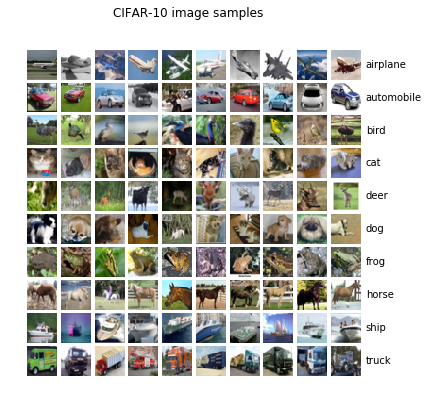

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# loading
with open('./dataset/cifar-10-batches-py/batches.meta', 'rb') as fm:
    cifar_meta = pickle.load(fm, encoding='bytes')
with open('./dataset/cifar-10-batches-py/data_batch_1', 'rb') as fd:
    cifar_data = pickle.load(fd, encoding='bytes')
data, labels = cifar_data[b'data'], np.array(cifar_data[b'labels'])

print(" --- CIFAR-10 informations --- ")
for t, item in zip(['the number of classes', 'labels', 'image data size'],cifar_meta.items()):
    print(t, ":", item[1])
print(" --- ")

# sample
fig, ax = plt.subplots(10,10, figsize=(6,6))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ax_i in enumerate(ax):
    targets = np.where(labels==i)[0]
    np.random.shuffle(targets)
    for j, (idx, ax_ij) in enumerate(zip(targets[:10], ax_i)):
        img = data[idx].reshape(3, 32, 32).transpose(1,2,0)
        ax_ij.imshow(img)
        ax_ij.axis('off')
        if j==9: fig.text(ax_ij.get_position().x1+0.01, ax_ij.get_position().y1-0.04, 
                          cifar_meta[b'label_names'][labels[idx]].decode())
plt.suptitle("CIFAR-10 image samples")
plt.show()

画像へのPCA適用については[CS231n](http://cs231n.github.io/neural-networks-2/#datapre)の設定にならい、  
1つの画像データを3072次元実数ベクトルとみなし、これを144次元へ次元削減する。    
　（Whiteningした画像の例が掲載されているが、どうもPCAではなくZCAによるwhiteningのようである）  
簡易化のため、データ数は49、ランダム抽出とする。   

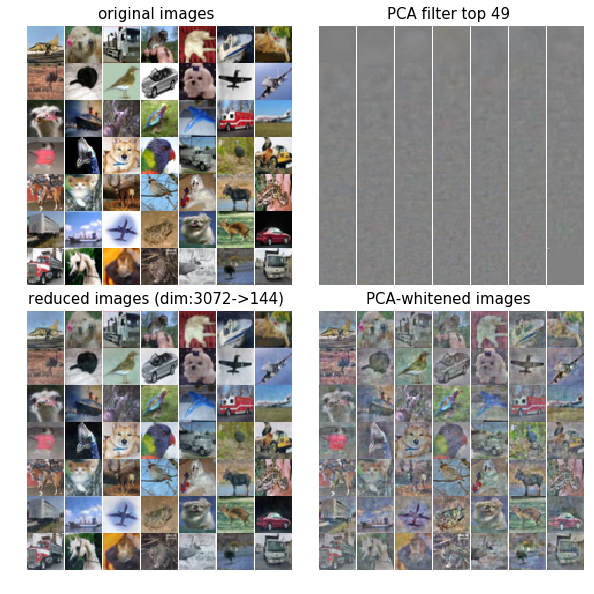

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

def pca_reduce_and_whitening(X, reduced_dim=144):
    Xc = X - np.mean(X, axis=0)
    cov = np.dot(Xc.T, Xc) / Xc.shape[0]
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(Xc, U)
    Xred = np.dot(Xc, U[:,:reduced_dim])
    Xwhite = Xred / np.sqrt(S[:reduced_dim] + 1e-8)
    return Xred, Xwhite, U

def extend(X,U, dim=144):
    return np.dot(X, U.transpose()[:dim,:])

def normalize_to_image(X, rangex=None):
    if rangex==None:
        minX, maxX = np.min(X), np.max(X)
    else:
        minX, maxX = rangex
    A = X-minX
    return A / np.max(A), (minX, maxX)
    

def plot_image(data, title, fign, tile, figsize=(12,12), extent=1):
    fig = plt.figure(figsize=figsize)
    outer_grid = gridspec.GridSpec(2, int(np.ceil(fign/2)), wspace=0.1, hspace=0.1)
    
    for i,t in zip(range(fign), title):
        inner_grid = gridspec.GridSpecFromSubplotSpec(tile[i], tile[i], 
                                                      subplot_spec=outer_grid[i], 
                                                      wspace=0.0, hspace=0.0)
        images = data[i][:tile[i]*tile[i]]
        
        for j, img in enumerate(images):
            ax = plt.Subplot(fig, inner_grid[j])
            img_shape = (np.sqrt(img.size/3).astype(int), np.sqrt(img.size/3).astype(int), 3)
            img = img.reshape(img_shape)
            ax.imshow(img.repeat(extent, axis=0).repeat(extent, axis=1))
            ax.axis('off')
            if j==0:
                ax.set_title(t, x=3.5, y=1.05, fontsize=15)
            fig.add_subplot(ax)
    plt.show()


# setting data
with open('./dataset/cifar-10-batches-py/batches.meta', 'rb') as fm:
    cifar_meta = pickle.load(fm, encoding='bytes')
with open('./dataset/cifar-10-batches-py/data_batch_1', 'rb') as fd:
    cifar_data = pickle.load(fd, encoding='bytes')
data, labels = cifar_data[b'data'], np.array(cifar_data[b'labels'])

targets=np.random.randint(0,10000, size=7*7)
X = np.array([data[t] for t in targets])/255

Xr = X.reshape(-1,3,32,32).transpose(0,2,3,1).reshape(-1, 3*32*32)
Xred, Xwhite, U = pca_reduce_and_whitening(Xr, reduced_dim=144)

Xredfix,_ = normalize_to_image(extend(Xred, U, dim=144))
Xwhitefix,_ = normalize_to_image(extend(Xwhite, U, dim=144))
Ufix,_ = normalize_to_image(U.T)[:49]

data=[Xr, Ufix, Xredfix, Xwhitefix]
title=["original images", "PCA filter top 49", "reduced images (dim:3072->144)", "PCA-whitened images"]

plot_image(data=data, title=title, fign=4, tile=[7,7,7,7], figsize=(10,10))


---
### Weight Initialization


勾配降下法と誤差逆伝播法によって学習を行うとき、  
重みの初期値が等しい各ノードは全く等しい値の誤差を受け取り、等しく更新されるため  
結果として１つのニューロンだけがあるのと同じ振る舞いをしてしまう。  
よって重みの初期値は同じ層のどの２つのノードも異なっていなければならず  
これには初期値の設定をランダム化する手法が使われる。  
  
また、学習中に誤差が全層に正しく伝わり、また値が大きくなり過ぎない、  
つまり不安定勾配問題を軽減するような初期値の分布であることが望ましい。  

CS231の講義での[Setting up the data and the model | Weight Initialization](http://cs231n.github.io/neural-networks-2/#init)の項では、経験則が次のようにまとめられている。
  
 - Small random numbers for symmetry breaking
 - Calibrating the variances with 1/sqrt(n) to ensures that all neurons initially have approximately the same output distribution

後者で言及されている出力の分布について検討する。  
前提として、入力データは正規化され、重みの分布の平均値が零であること、すなわち

\begin{align*}
E(x_{i}) = E(w_{ij}) = 0
\end{align*}

を仮定する。  
  
ある層への入力が $n$ 次元のベクトル $\mathbf{x}$ 、重みが $\mathbf{W}$ のとき、  
活性化関数へ入力される重み付き和 $\mathbf{p}$ の成分 $ p_{j} = \sum_{i=1}^{n}w_{ij}x_{i}$ の分散を考えると

\begin{align*}
Var(p_{j}) &= Var\left( \sum_{i=1}^{n}w_{ij}x_{i} \right) \\
&= \sum_{i=1}^{n} Var(w_{ij}x_{n}) \\
&= \sum_{i=1}^{n} \left\{ \left( E(w_{ij}) \right)^{2} Var(x_{i}) + \left( E(x_{i}) \right)^{2} Var(w_{ij}) + Var(w_{ij})Var(x_{i}) \right\} \\ 
&= \sum_{i=1}^{n} Var(x_{ij}) Var(w_{i}) & \because E(x_{i}) = E(w_{ij}) = 0\\
&= (n Var(w_{ij}))Var(x_{i})
\end{align*}

となる。  
  
さて、定数 $a$ に対して $Var(ax)=a^{2} Var(x)$ であるから、層の前後で出力分布が変わらないためには  
重みの初期値に係数 $1/ \sqrt{n}$ が乗算されていればよい。  
  


---
代表的な重みの初期値として、以下のようなものがよく知られている。  
ここで fan_in, fan_out は各層（Weight tensor）における入力／出力ユニット数である。

#### LuCunの初期値
[LeCun et al., (1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)で提唱された初期値で、
正規分布または一様分布による初期化を行う。

Kerasでは

~~~python
# truncated normal distribution | mean=0, stddev = sqrt(1 / fan_in)
initializer = "lecun_normal"

# uniform distribution | within [-sqrt(3 / fan_in), sqet(3 / fan_in)]
initializer = "lecun_uniform"
~~~

により使用できる。

#### Xavierの初期値
[Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a.html) で提唱された初期値で  
勾配の大きさを全体として一定に保つことを目的としており、  
前後の層のユニット数から $ Var(w) = \frac{2}{n_{in} + n_{out}}$ の標準偏差をもつ分布を使用するというものである。  
  
使用の際には、一様分布ならば `var = sqrt(6. / (n_in + n_out)); [-x, x]`が、  
正規分布ならば `var = sqrt(3. / (n_in + n_out))` が用いられる。  
  
[TensorFlow](https://www.tensorflow.org/versions/r0.12/api_docs/python/contrib.layers/initializers)では  

~~~python
tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
~~~
  
[Keras](https://keras.io/ja/initializers/)では initializerの指定部分で  

~~~python
# normal distribution
initializer = 'glorot_normal'

# uniform distribution
initializer = 'glorot_uniform'
~~~

によって使用できる。

#### Heの初期値
[He et al.(2015)](https://arxiv.org/abs/1502.01852)で提唱された初期値で、活性化関数としてReLUを使う場合の初期値分布である。  
  
Kerasでは  

~~~python
# trancated normal distribution | mean=0, stddev = sqrt(2/fan_in)
initializer = "he_normal"

# uniform distribution | within [-sqrt(6 / fan_in), sqrt(6 / fan_in)]
initializer = "hi_uniform"
~~~

によって使用できる。  

---
WIP

---
### Optimizer